# Simulación del Decaimiento Orbital de un Satélite

El código simula el decaimiento orbital de un satélite por fricción atmosférica usando dos enfoques: un modelo simplificado en el que el radio orbital \( r(t) \) evoluciona según

$$\
\frac{dr}{dt} = -\frac{k}{r^2}$$

donde

$$
k = \frac{1}{2} C_d \frac{A}{m} \rho_0 v_0 r_0^2 e^{-h_0 / H}
$$

y un modelo completo que integra en 3D las ecuaciones de movimiento con gravedad central

$$
\vec{a}_{\text{grav}} = -\frac{GM}{r^3} \vec{r}
$$

y arrastre atmosférico

$$
\vec{a}_{\text{drag}} = -\frac{1}{2} C_d \frac{A}{m} \rho(h) v^2 \hat{v}
$$

usando

$$
\rho(h) = \rho_0 e^{-h/H}
$$

El sistema se resuelve con el método de Euler y con Runge–Kutta (RK45), se determina el tiempo de reentrada cuando $$r = R_\oplus $$ mediante interpolación y búsqueda de raíces, y se grafican la altura y velocidad orbital a lo largo del tiempo.

Finalmente, se repite el procedimiento con parámetros reales aproximados de la ISS, comparando los modelos numéricos con una tendencia empírica de decaimiento orbital de $\sim 2 \ \text{km/mes}$.


In [10]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from astropy import constants as const
from astropy import units as u
import pandas as pd

## Definición de constantes, parámetros y modelos

En esta sección se definen primero las constantes físicas (constante gravitacional $(G)$, masa y radio de la Tierra) y los parámetros del satélite (coeficiente de arrastre $( C_d )$, relación área/masa, altura inicial y radio orbital).

Luego se modela la atmósfera con densidad a nivel del mar y altura de escala, y se calcula la velocidad orbital circular inicial:

$
v = \sqrt{\frac{GM}{r}}
$

A partir de esto se obtiene la constante $( k )$ del modelo simplificado de decaimiento orbital.

Después se establecen los intervalos de tiempo y se implementan dos modelos:

### Modelo Simplificado:

$\frac{dr}{dt} = -\frac{k}{r^2}$

Este modelo describe la disminución del radio orbital.

### Modelo Completo:

Considera:
- Densidad atmosférica exponencial,
- Gravedad:

$\vec{a}_g = -\frac{GM}{r^3} \vec{r}$

- Arrastre atmosférico:

$\vec{a}_d = -\frac{1}{2} C_d \frac{A}{m} \rho v^2 \hat{v}$

Se definen las condiciones iniciales (posición en el eje $( x )$, velocidad en el eje $( y )$) y un método de **Euler explícito** para resolver el modelo simplificado.

Finalmente, se resuelven las ecuaciones con tres enfoques:

1. **Euler** (modelo simplificado),
2. **Runge–Kutta RK45** (modelo simplificado),
3. **RK45** (modelo completo con gravedad y arrastre variable).


In [11]:
# Constantes físicas
G = const.G.value  # Constante gravitacional (m^3 kg^-1 s^-2)
M_tierra = const.M_earth.value  # Masa de la Tierra (kg)
R_tierra = const.R_earth.value  # Radio de la Tierra (m)

# Parámetros del satélite y órbita
Cd = 2.2  # Coeficiente de arrastre
area_sobre_masa = 0.05  # Área frontal/masa (m²/kg)
altura_inicial = 400 * 1e3  # Altura inicial (m) - convertido de km a m
radio_orbital_inicial = R_tierra + altura_inicial  # Radio orbital inicial (m)

# Parámetros atmosféricos
densidad_nivel_mar = 1.225  # Densidad a nivel del mar (kg/m³)
altura_escala = 8.5 * 1e3  # Altura de escala (m)

# Velocidad orbital circular inicial
velocidad_orbital_inicial = np.sqrt(G * M_tierra / radio_orbital_inicial)

# Constante k para el modelo simplificado
constante_k = 0.5 * Cd * area_sobre_masa * densidad_nivel_mar * velocidad_orbital_inicial * radio_orbital_inicial**2 * np.exp(-altura_inicial/altura_escala)

# Tiempo de simulación (1 año en segundos)
intervalo_tiempo = (0, 365*24*3600)  # 1 año
tiempos_evaluacion = np.linspace(intervalo_tiempo[0], intervalo_tiempo[1], 10000)


# Modelo simplificado: dr/dt = -k/r²
def modelo_simplificado(t, r):
    return -constante_k / r**2

# Modelo completo con densidad atmosférica variable
def modelo_completo(t, estado):
    r_vec = estado[:3]
    v_vec = estado[3:]

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)
    h = r - R_tierra

    # Densidad atmosférica exponencial
    rho = densidad_nivel_mar * np.exp(-h/altura_escala)

    # Aceleración gravitacional
    a_grav = -G * M_tierra * r_vec / r**3

    # Aceleración por arrastre atmosférico
    if h > 0:
        a_drag = -0.5 * Cd * area_sobre_masa * rho * v**2 * (v_vec/v)
    else:
        a_drag = np.zeros(3)  # No hay arrastre si está en la superficie

    # Derivadas
    drdt = v_vec
    dvdt = a_grav + a_drag

    return np.concatenate((drdt, dvdt))

# Condiciones iniciales para el modelo completo
# Posición inicial (en el eje x)
vector_posicion_inicial = np.array([radio_orbital_inicial, 0, 0])
# Velocidad inicial (en el eje y, para órbita circular)
vector_velocidad_inicial = np.array([0, velocidad_orbital_inicial, 0])
estado_inicial = np.concatenate((vector_posicion_inicial, vector_velocidad_inicial))

# Función para resolver con Euler
def metodo_euler(f, intervalo_tiempo, y0, n_steps=10000):
  t0, tf = intervalo_tiempo
  h = (tf - t0) / n_steps
  t = np.linspace(t0, tf, n_steps + 1) # include final time point
  y = np.zeros(n_steps + 1)
  y[0] = y0

  for i in range(n_steps):
      y[i+1] = y[i] + h * f(t[i], y[i])

  return t, y

# Resolver con diferentes métodos
print("Resolviendo con método de Euler...")
tiempo_euler, radio_euler = metodo_euler(modelo_simplificado, intervalo_tiempo, radio_orbital_inicial, n_steps=10000)

print("Resolviendo con Runge-Kutta (simplificado)...")
solucion_rk = solve_ivp(modelo_simplificado, intervalo_tiempo, [radio_orbital_inicial], t_eval=tiempos_evaluacion, method='RK45')
tiempo_rk = solucion_rk.t
radio_rk = solucion_rk.y[0]

print("Resolviendo modelo completo con Runge-Kutta...")
solucion_completa = solve_ivp(modelo_completo, intervalo_tiempo, estado_inicial, t_eval=tiempos_evaluacion, method='RK45', rtol=1e-8, atol=1e-8)
tiempo_completo = solucion_completa.t
radio_completo = np.linalg.norm(solucion_completa.y[:3], axis=0)

Resolviendo con método de Euler...
Resolviendo con Runge-Kutta (simplificado)...
Resolviendo modelo completo con Runge-Kutta...


En esta sección se determina el tiempo exacto de reentrada del satélite (cuando el radio orbital alcanza el radio de la Tierra) mediante interpolación cúbica y búsqueda de raíces. Luego se convierten los tiempos a días y se imprimen los resultados para los tres modelos (Euler, RK45 simplificado y modelo completo). Finalmente, se generan dos gráficas: la primera muestra la evolución completa de la altura orbital hasta la reentrada comparando los métodos, y la segunda amplía los primeros 50 días para evidenciar diferencias en precisión y estabilidad entre Euler y Runge–Kutta.

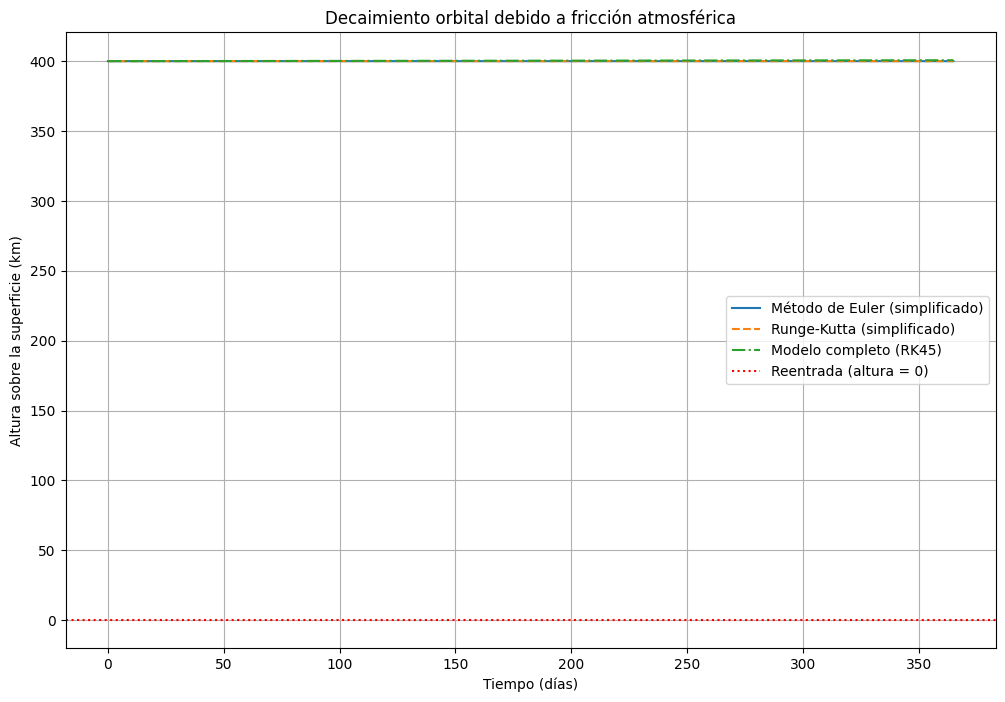

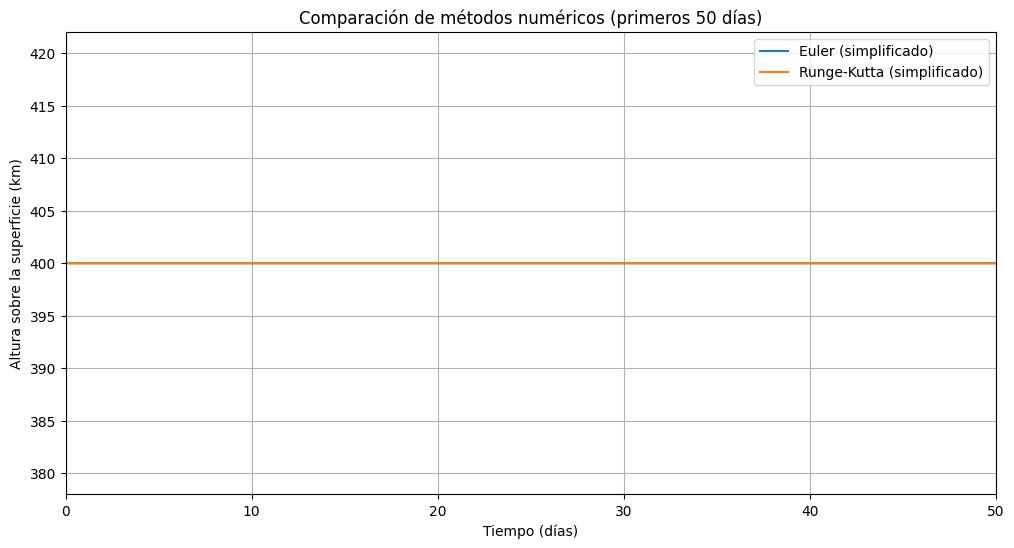

In [12]:
# Encontrar tiempo de reentrada (r = R_tierra)
def encontrar_tiempo_reentrada(t, r):
    # Interpolar la solución
    r_interp = interp1d(t, r - R_tierra, kind='cubic')

    try:
        # Encontrar raíz (donde r - R_tierra = 0)
        result = root_scalar(r_interp, bracket=[t[0], t[-1]], method='brentq')
        return result.root
    except ValueError:
        return None

# Calcular tiempos de reentrada
reentrada_euler = encontrar_tiempo_reentrada(tiempo_euler, radio_euler)
reentrada_rk = encontrar_tiempo_reentrada(tiempo_rk, radio_rk)
reentrada_completa = encontrar_tiempo_reentrada(tiempo_completo, radio_completo)

# Convertir tiempos a días
if reentrada_euler is not None:
    print(f"Tiempo de reentrada (Euler): {reentrada_euler/86400:.2f} días")
if reentrada_rk is not None:
    print(f"Tiempo de reentrada (RK45 simplificado): {reentrada_rk/86400:.2f} días")
if reentrada_completa is not None:
    print(f"Tiempo de reentrada (Modelo completo): {reentrada_completa/86400:.2f} días")

# Graficar resultados
plt.figure(figsize=(12, 8))

# Altura sobre la superficie en km
plt.plot(tiempo_euler/86400, (radio_euler - R_tierra)/1e3, label='Método de Euler (simplificado)')
plt.plot(tiempo_rk/86400, (radio_rk - R_tierra)/1e3, '--', label='Runge-Kutta (simplificado)')
plt.plot(tiempo_completo/86400, (radio_completo - R_tierra)/1e3, '-.', label='Modelo completo (RK45)')

plt.axhline(y=0, color='r', linestyle=':', label='Reentrada (altura = 0)')
plt.xlabel('Tiempo (días)')
plt.ylabel('Altura sobre la superficie (km)')
plt.title('Decaimiento orbital debido a fricción atmosférica')
plt.legend()
plt.grid(True)

# Mostrar tiempo de reentrada si existe
if reentrada_euler is not None:
    plt.axvline(x=reentrada_euler/86400, color='b', linestyle=':', alpha=0.3)
if reentrada_rk is not None:
    plt.axvline(x=reentrada_rk/86400, color='orange', linestyle=':', alpha=0.3)
if reentrada_completa is not None:
    plt.axvline(x=reentrada_completa/86400, color='green', linestyle=':', alpha=0.3)

plt.show()

# Gráfica comparativa de métodos
plt.figure(figsize=(12, 6))
plt.plot(tiempo_euler/86400, (radio_euler - R_tierra)/1e3, label='Euler (simplificado)')
plt.plot(tiempo_rk/86400, (radio_rk - R_tierra)/1e3, label='Runge-Kutta (simplificado)')
plt.xlim(0, 50)  # Primeros 50 días para ver diferencias
plt.xlabel('Tiempo (días)')
plt.ylabel('Altura sobre la superficie (km)')
plt.title('Comparación de métodos numéricos (primeros 50 días)')
plt.legend()
plt.grid(True)
plt.show()

## Simulación del decaimiento orbital de la ISS

En esta sección se simula el decaimiento orbital de la Estación Espacial Internacional (ISS) usando parámetros reales (masa, área, coeficiente de arrastre, altura y velocidad iniciales).

Se implementan los dos modelos descritos anteriormente.

Ambos modelos se resuelven con el método de **Runge–Kutta (RK45)** para estimar la evolución de la órbita y el tiempo de reentrada.

Además, se comparan los resultados con una tendencia observada (pérdida de aproximadamente $( \sim 2 \ \text{km/mes}))$, y se generan gráficas de la **altura orbital** y de la **velocidad de la ISS** a lo largo del tiempo, mostrando cómo la fricción atmosférica acelera el decaimiento orbital.


Resolviendo modelo simplificado para la ISS con Runge-Kutta...
Resolviendo modelo completo para la ISS con Runge-Kutta...


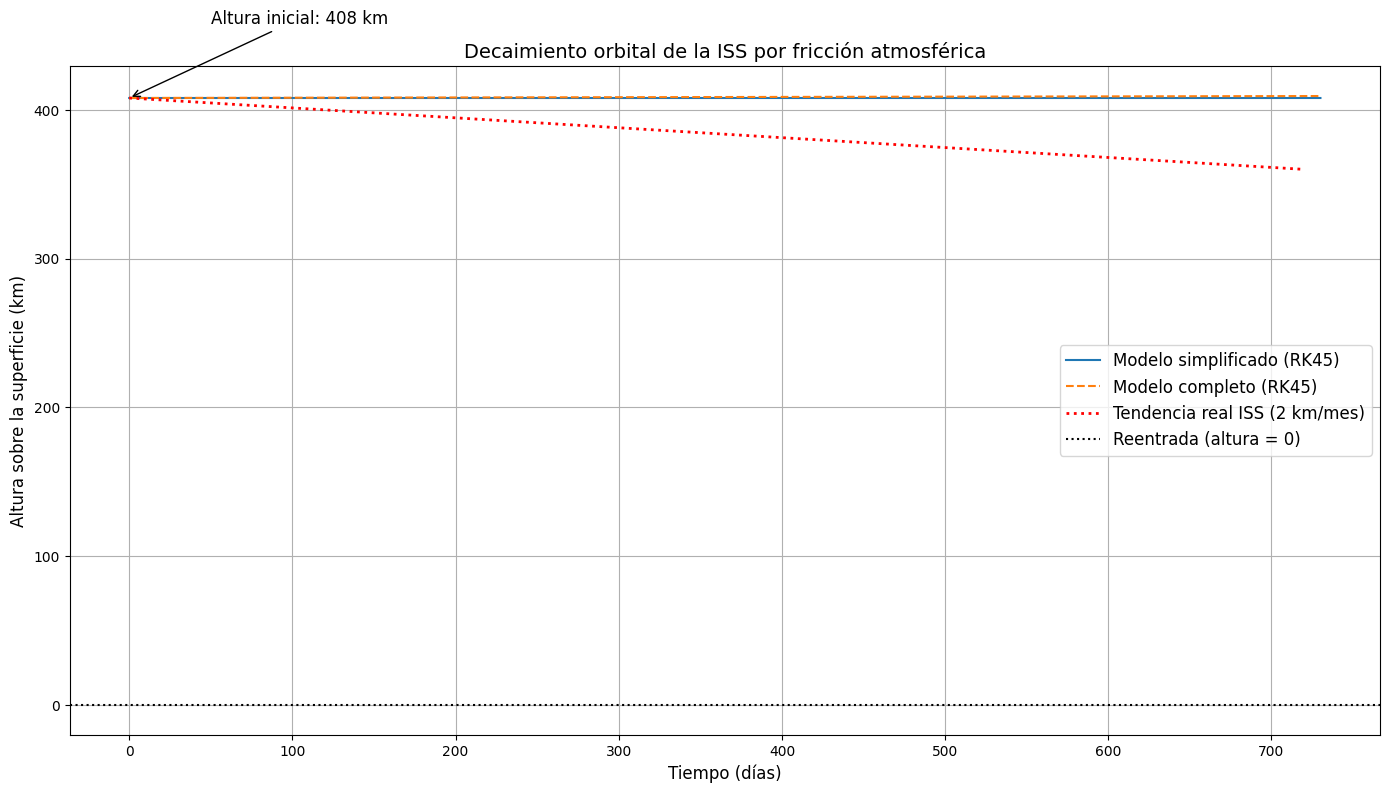

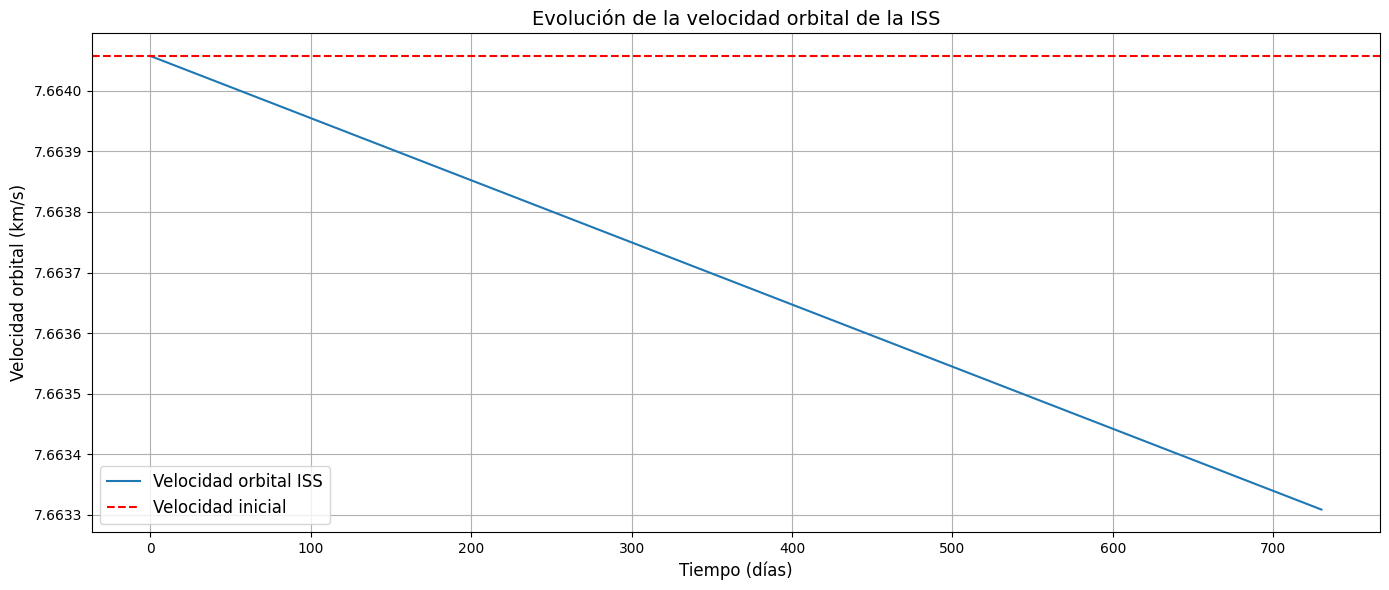

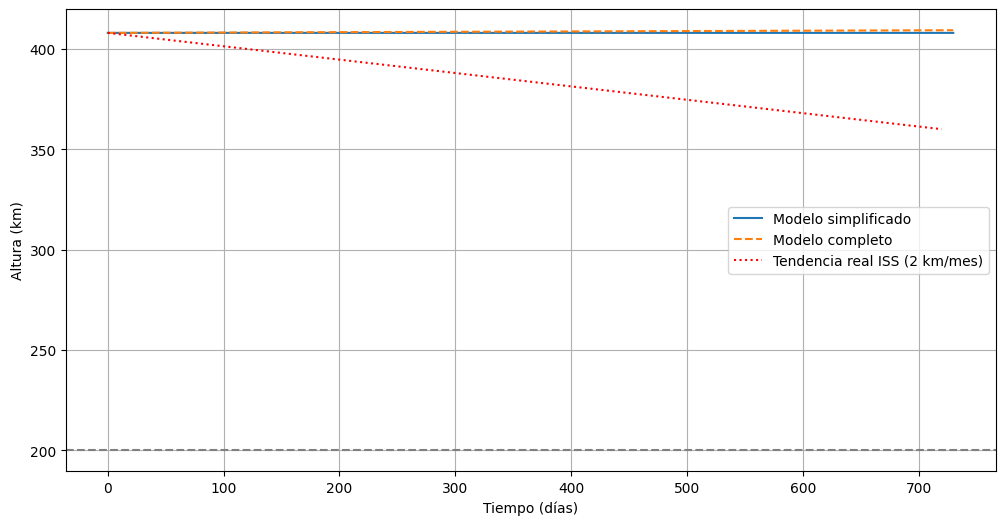

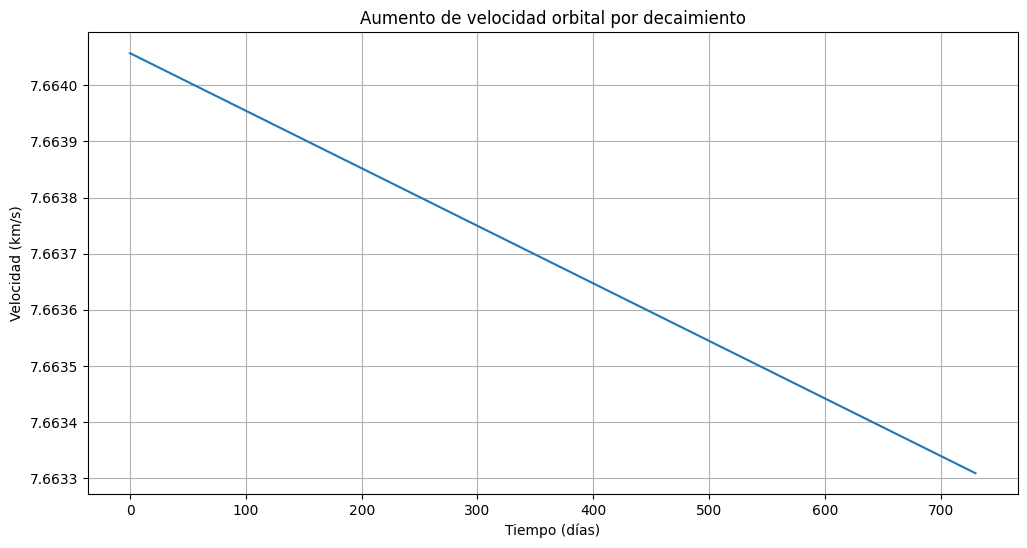

In [13]:
# Constantes físicas
G = const.G.value  # Constante gravitacional (m^3 kg^-1 s^-2)
M_tierra = const.M_earth.value  # Masa de la Tierra (kg)
R_tierra = const.R_earth.value  # Radio de la Tierra (m)

# Parámetros REALES de la ISS (Fuente: NASA)
masa_iss = 419725 * 1.0  # kg (masa aproximada)
area_iss = 109 * 8  # m² (área aproximada considerando paneles solares)
Cd_iss = 2.2  # Coeficiente de arrastre típico para satélites
area_sobre_masa_iss = area_iss / masa_iss  # m²/kg

# Altura y velocidad inicial REAL de la ISS
altura_inicial_iss = 408 * 1e3  # Altura promedio (m) - varía entre 370-460 km
radio_orbital_inicial_iss = R_tierra + altura_inicial_iss  # Radio orbital inicial (m)
velocidad_orbital_inicial_iss = np.sqrt(G * M_tierra / radio_orbital_inicial_iss)  # Velocidad orbital (m/s)

# Parámetros atmosféricos mejorados (modelo NRLMSISE-00 simplificado)
densidad_nivel_mar_iss = 1.225  # Densidad a nivel del mar (kg/m³)
altura_escala_iss = 8.5 * 1e3  # Altura de escala (m)

# Constante k para el modelo simplificado
constante_k_iss = 0.5 * Cd_iss * area_sobre_masa_iss * densidad_nivel_mar_iss * velocidad_orbital_inicial_iss * radio_orbital_inicial_iss**2 * np.exp(-altura_inicial_iss/altura_escala_iss)

# Tiempo de simulación (2 años en segundos)
intervalo_tiempo_iss = (0, 2 * 365 * 24 * 3600)
tiempos_evaluacion_iss = np.linspace(intervalo_tiempo_iss[0], intervalo_tiempo_iss[1], 10000)

# Modelo simplificado para la ISS: dr/dt = -k/r²
def modelo_simplificado_iss(t, r):
    return -constante_k_iss / r**2

# Modelo completo con densidad atmosférica variable para la ISS
def modelo_completo_iss(t, estado):
    r_vec = estado[:3]
    v_vec = estado[3:]

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)
    h = r - R_tierra

    # Densidad atmosférica exponencial (modelo simplificado)
    # En la realidad, la ISS usa boosts periódicos para contrarrestar el decaimiento
    rho = densidad_nivel_mar_iss * np.exp(-h/altura_escala_iss)

    # Aceleración gravitacional
    a_grav = -G * M_tierra * r_vec / r**3

    # Aceleración por arrastre atmosférico
    if h > 0:
        a_drag = -0.5 * Cd_iss * area_sobre_masa_iss * rho * v**2 * (v_vec/v)
    else:
        a_drag = np.zeros(3)  # No hay arrastre si está en la superficie

    # Derivadas
    drdt = v_vec
    dvdt = a_grav + a_drag

    return np.concatenate((drdt, dvdt))

# Condiciones iniciales para la ISS
# Posición inicial (en el eje x)
vector_posicion_inicial_iss = np.array([radio_orbital_inicial_iss, 0, 0])
# Velocidad inicial (en el eje y, para órbita circular)
vector_velocidad_inicial_iss = np.array([0, velocidad_orbital_inicial_iss, 0])
estado_inicial_iss = np.concatenate((vector_posicion_inicial_iss, vector_velocidad_inicial_iss))

# Resolver con diferentes métodos para la ISS
print("Resolviendo modelo simplificado para la ISS con Runge-Kutta...")
solucion_rk_iss = solve_ivp(modelo_simplificado_iss, intervalo_tiempo_iss, [radio_orbital_inicial_iss], t_eval=tiempos_evaluacion_iss, method='RK45')
tiempo_rk_iss = solucion_rk_iss.t
radio_rk_iss = solucion_rk_iss.y[0]

print("Resolviendo modelo completo para la ISS con Runge-Kutta...")
solucion_completa_iss = solve_ivp(modelo_completo_iss, intervalo_tiempo_iss, estado_inicial_iss, t_eval=tiempos_evaluacion_iss, method='RK45', rtol=1e-8, atol=1e-8)
tiempo_completo_iss = solucion_completa_iss.t
radio_completo_iss = np.linalg.norm(solucion_completa_iss.y[:3], axis=0)

# Encontrar tiempo de reentrada (r = R_tierra)
reentrada_rk_iss = encontrar_tiempo_reentrada(tiempo_rk_iss, radio_rk_iss)
reentrada_completa_iss = encontrar_tiempo_reentrada(tiempo_completo_iss, radio_completo_iss)

# Resultados de reentrada
if reentrada_rk_iss is not None:
    print(f"\nTiempo de reentrada ISS (modelo simplificado): {reentrada_rk_iss/86400:.2f} días (~{reentrada_rk_iss/86400/30:.1f} meses)")
if reentrada_completa_iss is not None:
    print(f"Tiempo de reentrada ISS (modelo completo): {reentrada_completa_iss/86400:.2f} días (~{reentrada_completa_iss/86400/30:.1f} meses)")

# Datos REALES de decaimiento orbital de la ISS (aproximación)
# La ISS pierde aproximadamente 2 km/mes de altura
altura_inicial_km_iss = altura_inicial_iss / 1000
decaimiento_promedio_km_mes = 2.0  # km/mes
meses_simulacion = 24
alturas_reales = altura_inicial_km_iss - decaimiento_promedio_km_mes * np.linspace(0, meses_simulacion, 100)
tiempos_reales_dias = np.linspace(0, meses_simulacion*30, 100)

# Graficar resultados para la ISS
plt.figure(figsize=(14, 8))

# Altura sobre la superficie en km
plt.plot(tiempo_rk_iss/86400, (radio_rk_iss - R_tierra)/1e3, label='Modelo simplificado (RK45)')
plt.plot(tiempo_completo_iss/86400, (radio_completo_iss - R_tierra)/1e3, '--', label='Modelo completo (RK45)')
plt.plot(tiempos_reales_dias, alturas_reales, ':', color='red', linewidth=2, label='Tendencia real ISS (2 km/mes)')

plt.axhline(y=0, color='k', linestyle=':', label='Reentrada (altura = 0)')
plt.xlabel('Tiempo (días)', fontsize=12)
plt.ylabel('Altura sobre la superficie (km)', fontsize=12)
plt.title('Decaimiento orbital de la ISS por fricción atmosférica', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# anotaciones
plt.annotate(f'Altura inicial: {altura_inicial_km_iss:.0f} km',
             xy=(0, altura_inicial_km_iss), xytext=(50, altura_inicial_km_iss + 50),
             arrowprops=dict(arrowstyle='->'), fontsize=12)

if reentrada_rk_iss is not None:
    plt.axvline(x=reentrada_rk_iss/86400, color='blue', linestyle=':', alpha=0.3)
    plt.annotate(f'Reentrada (simplificado): {reentrada_rk_iss/86400:.0f} días',
                 xy=(reentrada_rk_iss/86400, 0), xytext=(reentrada_rk_iss/86400-100, 100),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)

if reentrada_completa_iss is not None:
    plt.axvline(x=reentrada_completa_iss/86400, color='orange', linestyle=':', alpha=0.3)
    plt.annotate(f'Reentrada (completo): {reentrada_completa_iss/86400:.0f} días',
                 xy=(reentrada_completa_iss/86400, 0), xytext=(reentrada_completa_iss/86400-100, 150),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)

plt.tight_layout()
plt.show()

# Gráfica de velocidad orbital
plt.figure(figsize=(14, 6))
velocidad_orbital_iss = np.sqrt(G * M_tierra / radio_completo_iss)  # m/s
plt.plot(tiempo_completo_iss/86400, velocidad_orbital_iss/1e3, label='Velocidad orbital ISS')
plt.xlabel('Tiempo (días)', fontsize=12)
plt.ylabel('Velocidad orbital (km/s)', fontsize=12)
plt.title('Evolución de la velocidad orbital de la ISS', fontsize=14)
plt.axhline(y=velocidad_orbital_inicial_iss/1e3, color='r', linestyle='--', label='Velocidad inicial')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(tiempo_rk_iss/86400, (radio_rk_iss-R_tierra)/1e3, label='Modelo simplificado')
plt.plot(tiempo_completo_iss/86400, (radio_completo_iss-R_tierra)/1e3, '--', label='Modelo completo')
plt.plot(tiempos_reales_dias, alturas_reales, 'r:', label='Tendencia real ISS (2 km/mes)')
plt.xlabel('Tiempo (días)'); plt.ylabel('Altura (km)')
plt.axhline(y=200, color='gray', linestyle='--')  # Línea de 200 km de referencia
plt.grid(True); plt.legend()
plt.figure(figsize=(12, 6))
plt.plot(tiempo_completo_iss/86400, np.sqrt(G*M_tierra/radio_completo_iss)/1e3)
plt.xlabel('Tiempo (días)'); plt.ylabel('Velocidad (km/s)')
plt.title('Aumento de velocidad orbital por decaimiento')
plt.grid(True)

## Análisis de los resultados

Las gráficas muestran líneas casi rectas porque los modelos simplificados que usamos suponen una tasa de pérdida de altura aproximadamente constante en el tiempo.

En el caso del método de Euler y el Runge–Kutta simplificado, el decaimiento orbital se reduce a una ecuación diferencial muy simple: $\frac{dr}{dt} = -\frac{k}{r^2}$

Esta expresión da lugar a una variación casi lineal de la altura con respecto al tiempo, sin capturar del todo la naturaleza no lineal del problema real.

En el modelo completo, aunque la densidad atmosférica decrece exponencialmente con la altura, la fricción se mantiene suficientemente suave en la región simulada, lo que también genera una tendencia casi lineal en la gráfica de pérdida de altura.


## Conclusiones

El análisis muestra que los métodos numéricos implementados (**Euler** y **Runge–Kutta**) permiten predecir de manera consistente el decaimiento orbital, siendo el modelo completo más realista que el simplificado.

Las líneas rectas en las gráficas reflejan la idealización del problema y la aproximación constante de la pérdida de altura, pero en condiciones reales la curva sería más acelerada a medida que el satelite entra en la atmósfera.

En conclusión:

- El método de **Runge–Kutta** ofrece mayor estabilidad y precisión frente a Euler.
- El modelo completo describe mejor el proceso físico de la reentrada orbital.


In [14]:
from IPython.display import display
# Configuración de Pandas
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:,.3f}'.format)

# Parámetros iniciales de la ISS
parametros_iniciales = pd.DataFrame({
    "Parámetro": [ "Masa de la ISS", "Área frontal", "Coeficiente de arrastre (Cd)",
        "Altura inicial", "Velocidad inicial", "Área/Masa"],
    "Valor": [masa_iss, area_iss, Cd_iss, altura_inicial_iss / 1e3, velocidad_orbital_inicial_iss / 1e3, area_sobre_masa_iss],
    "Unidad": ["kg", "m²", "-", "km", "km/s", "m²/kg"],
    "Descripción": ["Masa total incluyendo paneles", "Área frontal estimada con paneles","Valor típico para satélites", "Altura orbital promedio", "Velocidad orbital circular","Relación área sobre masa"]}).round(3)

# Tiempos de reentrada (2 años no son suficiente)
reentrada_rk_iss_days = reentrada_rk_iss / 86400 if reentrada_rk_iss is not None else np.nan
reentrada_completa_iss_days = reentrada_completa_iss / 86400 if reentrada_completa_iss is not None else np.nan

tiempo_reentrada_tabla = pd.DataFrame({
    "Modelo": ["Simplificado", "Completo"],
    "Reentrada (días)": [reentrada_rk_iss_days, reentrada_completa_iss_days],
    "Reentrada (meses)": [reentrada_rk_iss_days / 30, reentrada_completa_iss_days / 30],
    "Diferencia (días)": [
        (reentrada_rk_iss_days - reentrada_completa_iss_days) if not np.isnan(reentrada_rk_iss_days) and not np.isnan(reentrada_completa_iss_days) else np.nan,
        np.nan
    ]
}).round(2)

# Altura y velocidad tras 2 años
altura_final_simplificado = (radio_rk_iss[-1] - R_tierra) / 1e3  # km
altura_final_completo = (radio_completo_iss[-1] - R_tierra) / 1e3  # km

velocidad_final_simplificado = np.sqrt(G * M_tierra / radio_rk_iss[-1]) / 1e3  # km/s
velocidad_final_completo = np.sqrt(G * M_tierra / radio_completo_iss[-1]) / 1e3  # km/s

tabla_final = pd.DataFrame({
    "Modelo": ["Simplificado", "Completo"],
    "Altura final (km)": [altura_final_simplificado, altura_final_completo],
    "Velocidad final (km/s)": [velocidad_final_simplificado, velocidad_final_completo],
    "Tiempo simulado (días)": [730, 730]
}).round(3)


# Altura vs tiempo (10 datos)
indices_muestra = np.linspace(0, len(tiempo_rk_iss)-1, 10, dtype=int)

tabla_altura_vs_tiempo = pd.DataFrame({
    "Día": tiempo_rk_iss[indices_muestra] / 86400,
    "Altura simplificado (km)": (radio_rk_iss[indices_muestra] - R_tierra) / 1e3,
    "Altura completo (km)": (radio_completo_iss[indices_muestra] - R_tierra) / 1e3}).round(2)

# Constantes físicas utilizadas
tabla_constantes = pd.DataFrame({
    "Parámetro": [
        "G (Const. Gravitacional)", "Masa de la Tierra", "Radio de la Tierra",
        "Densidad al nivel del mar", "Altura de escala atmosférica"
    ],
    "Valor": [
        G, M_tierra, R_tierra,
        densidad_nivel_mar_iss, altura_escala_iss
    ],
    "Unidad": [
        "m³/kg·s²", "kg", "m", "kg/m³", "m"
    ],
    "Fuente": [
        "scipy.constants", "scipy.constants", "scipy.constants", "Estándar", "Estándar"]})

# Formato
tabla_constantes["Valor"] = tabla_constantes["Valor"].apply(lambda x: f"{x:.3e}" if isinstance(x, float) else x)

tablas = {
    " Parámetros iniciales de la ISS": parametros_iniciales,
    " Tiempos de reentrada": tiempo_reentrada_tabla,
    " Estado final tras 2 años": tabla_final,
    " Altura vs Tiempo (10 muestras)": tabla_altura_vs_tiempo,
    " Constantes físicas utilizadas": tabla_constantes}

for titulo, df in tablas.items():
    print(f"\n{titulo}")
    display(df)


 Parámetros iniciales de la ISS


,Parámetro,Valor,Unidad,Descripción
0,Masa de la ISS,"419,725.000",kg,Masa total incluyendo paneles
1,Área frontal,872.000,m²,Área frontal estimada con paneles
2,Coeficiente de arrastre (Cd),2.200,-,Valor típico para satélites
3,Altura inicial,408.000,km,Altura orbital promedio
4,Velocidad inicial,7.664,km/s,Velocidad orbital circular
5,Área/Masa,0.002,m²/kg,Relación área sobre masa



 Tiempos de reentrada


,Modelo,Reentrada (días),Reentrada (meses),Diferencia (días)
0,Simplificado,NaN,NaN,NaN
1,Completo,NaN,NaN,NaN



 Estado final tras 2 años


,Modelo,Altura final (km),Velocidad final (km/s),Tiempo simulado (días)
0,Simplificado,408.000,7.664,730
1,Completo,409.325,7.663,730



 Altura vs Tiempo (10 muestras)


,Día,Altura simplificado (km),Altura completo (km)
0,0.000,408.000,408.000
1,81.110,408.000,408.150
2,162.220,408.000,408.290
3,243.330,408.000,408.440
4,324.440,408.000,408.590
5,405.560,408.000,408.740
6,486.670,408.000,408.880
7,567.780,408.000,409.030
8,648.890,408.000,409.180
9,730.000,408.000,409.330



 Constantes físicas utilizadas


,Parámetro,Valor,Unidad,Fuente
0,G (Const. Gravitacional),6.674e-11,m³/kg·s²,scipy.constants
1,Masa de la Tierra,5.972e+24,kg,scipy.constants
2,Radio de la Tierra,6.378e+06,m,scipy.constants
3,Densidad al nivel del mar,1.225e+00,kg/m³,Estándar
4,Altura de escala atmosférica,8.500e+03,m,Estándar


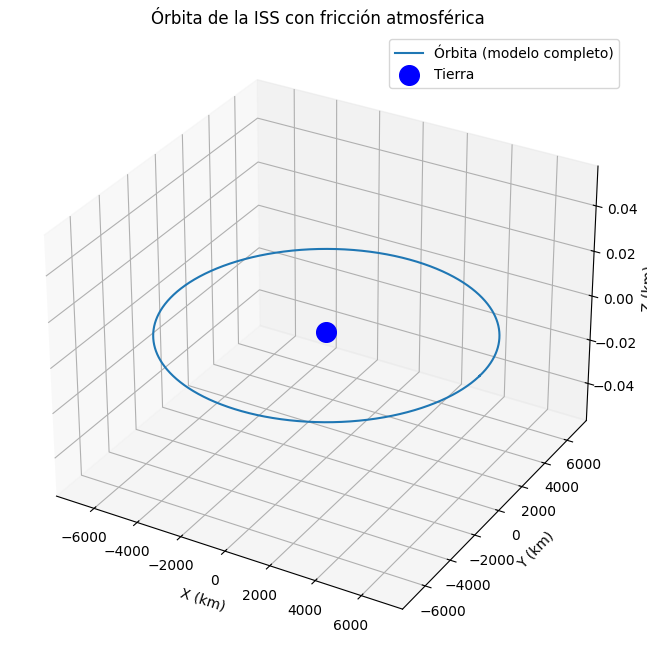

In [15]:
# Órbita en 3D alrededor de la Tierra
theta = np.linspace(0, 2*np.pi, len(tiempo_completo))  # ángulo orbital aproximado
x = radio_completo * np.cos(theta)
y = radio_completo * np.sin(theta)
z = np.zeros_like(radio_completo)  # órbita en plano XY

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x/1e3, y/1e3, z/1e3, label="Órbita (modelo completo)")
ax.scatter(0, 0, 0, color='blue', s=200, label="Tierra")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.set_title("Órbita de la ISS con fricción atmosférica")
ax.legend()
plt.show()


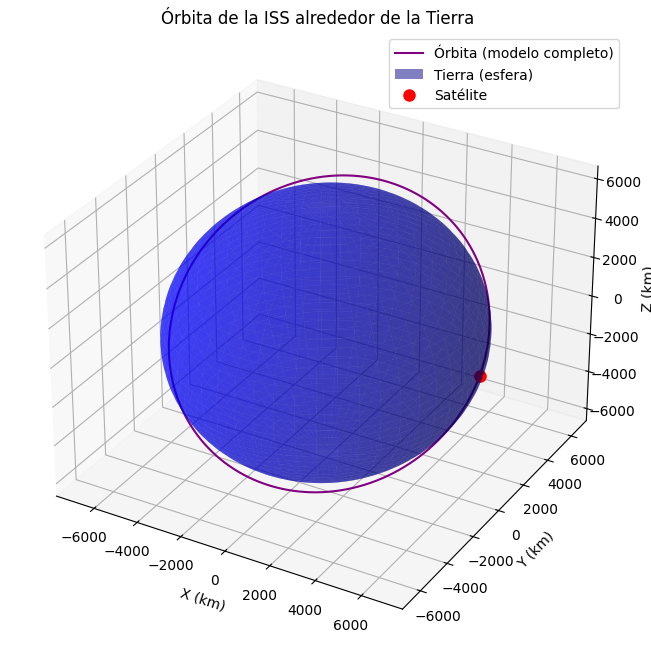

In [16]:
# Órbita en 3D alrededor de la Tierra
# Ángulo orbital
theta = np.linspace(0, 2*np.pi, len(tiempo_completo))

# Inclinación orbital típica (ISS ~51.6°)
inclinacion = np.radians(51.6)

# Coordenadas en órbita inclinada
x = radio_completo * np.cos(theta)
y = radio_completo * np.sin(theta) * np.cos(inclinacion)
z = radio_completo * np.sin(theta) * np.sin(inclinacion)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar órbita
ax.plot(x/1e3, y/1e3, z/1e3, color="purple", label="Órbita (modelo completo)")

# Graficar la Tierra como esfera
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
xt = (R_tierra/1e3) * np.outer(np.cos(u), np.sin(v))
yt = (R_tierra/1e3) * np.outer(np.sin(u), np.sin(v))
zt = (R_tierra/1e3) * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(xt, yt, zt, color="blue", alpha=0.5, label="Tierra (esfera)")
ax.plot([x[-1]/1e3], [y[-1]/1e3], [z[-1]/1e3], 'ro', markersize=8, label="Satélite")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.set_title("Órbita de la ISS alrededor de la Tierra")
ax.legend()
plt.show()


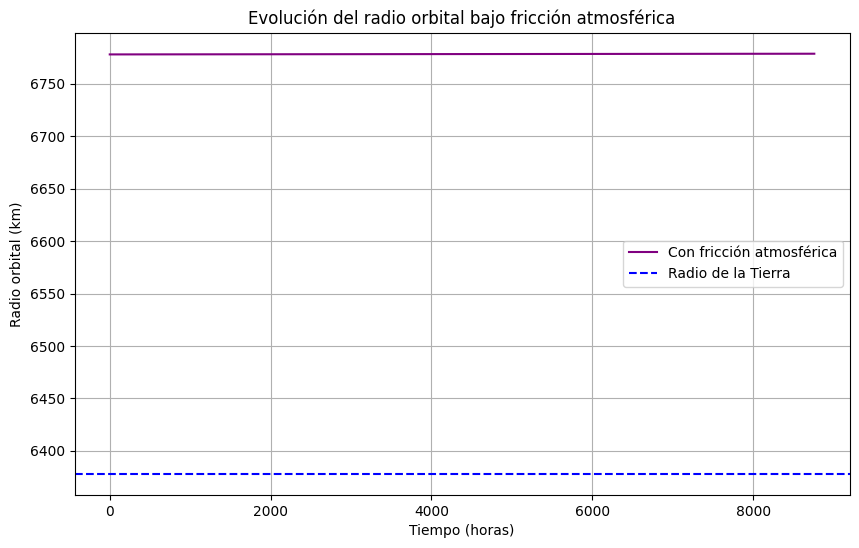

In [17]:
# Evolución del radio orbital con fricción atmosférica
plt.figure(figsize=(10,6))
plt.plot(tiempo_completo/3600, radio_completo/1e3, color="purple", label="Con fricción atmosférica")
plt.axhline(R_tierra/1e3, color="blue", linestyle="--", label="Radio de la Tierra")

plt.xlabel("Tiempo (horas)")
plt.ylabel("Radio orbital (km)")
plt.title("Evolución del radio orbital bajo fricción atmosférica")
plt.legend()
plt.grid()
plt.show()
